In [1]:
!pip install transformers
!pip install tqdm


In [2]:
!git clone https://github.com/KhacDiep08/MusicChatbot


Cloning into 'MusicChatbot'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 77 (delta 27), reused 66 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 485.04 KiB | 9.51 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [3]:
import os
print(os.getcwd())


/content


In [4]:
import sys
import os

# Thêm thư mục chứa mood_data.py và mood_model.py vào sys.path
sys.path.append('/content/MusicChatbot/model/mood_prediction')

# Kiểm tra path hiện tại (không bắt buộc)
print(os.getcwd())


/content


In [10]:
from mood_data import BuildData
from mood_model import BuildModel
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import DatasetDict

In [6]:
from mood_data import BuildData

# Khởi tạo với mô hình bạn đang dùng (distilbert)
data_builder = BuildData(csv_path="/content/MusicChatbot/data/processed/mood_prediction_model/filtered_dataset.csv", model_name="distilbert-base-uncased")

# Load và chuẩn hóa dữ liệu
dataset = data_builder.load_and_prepare_data()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

In [7]:
import pandas as pd

# Đọc file CSV để in ra bảng gốc (nếu bạn muốn nhìn rõ hơn)
df = pd.read_csv("/content/MusicChatbot/data/processed/mood_prediction_model/filtered_dataset.csv")[['lyrics', 'mood']].dropna()
print(df.head(5))


                                              lyrics     mood
0  friends told her she was better off at the bot...  sadness
1  well i heard it playing soft from a drunken ba...  sadness
2  oh my god did i just say that out loud should'...      joy
3  remember when i called you on the telephone yo...      joy
4  we've known working in obscurity and we'll kno...  sadness


/tmp/ipython-input-1265446400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_all, x='label_name', order=['joy', 'sadness', 'anger', 'fear'], palette='pastel')


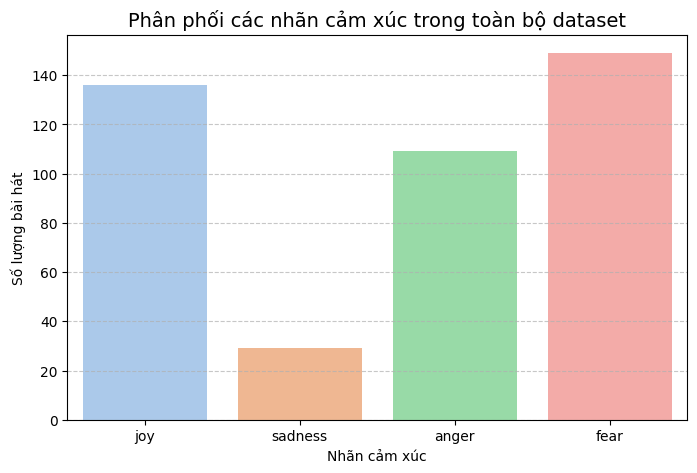

In [16]:
df_all = pd.concat([split.to_pandas() for split in dataset.values()], ignore_index=True)

# Ánh xạ label từ số → tên cho dễ nhìn
id2label = {0: 'joy', 1: 'sadness', 2: 'anger', 3: 'fear'}
df_all['label_name'] = df_all['label'].map(id2label)

# Vẽ biểu đồ đếm số lượng mỗi nhãn
plt.figure(figsize=(8, 5))
sns.countplot(data=df_all, x='label_name', order=['joy', 'sadness', 'anger', 'fear'], palette='pastel')
plt.title('Phân phối các nhãn cảm xúc trong toàn bộ dataset', fontsize=14)
plt.xlabel('Nhãn cảm xúc')
plt.ylabel('Số lượng bài hát')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# In vài mẫu token hóa
print(dataset['train'][10])  # hoặc dùng [i] với các index khác


{'label': tensor(2), 'input_ids': tensor([  101,  2028,  4392,  2048,  8974,  2093,  8974,  2176,  2016,  2018,
         2159,  2008,  1045,  2481,  1005,  1056,  8568, 11834,  3064,  2014,
         2039,  2041,  2006,  1996,  3153,  2723,  2016,  2001,  2041,  1997,
        15001,  2061,  1045,  2939,  2014,  2000,  1996,  3573,  9764,  2766,
         2039,  3724,  2039,  2114,  1996,  2813,  2021,  2016, 19623,  2074,
         1996,  2202,  1037,  2655, 23459,  2758,  2611,  2054,  1996,  6616,
         2024,  2017,  2725,  2035,  2122,  3337,  2024,  6069,  2022,  2115,
        10083,  2085,  1045,  2064,  1005,  1056,  2393,  2021,  2058, 26560,
         2004,  1045,  1005,  1049,  7618,  2013,  2014,  3300,  2000,  2014,
         4540,  2092,  2065,  2151,  1997,  2068,  3214,  2009,  1045,  1005,
         1040,  2812,  2009,  2067,  2009,  2196,  3214,  2505,  2021,  1037,
         2553,  1997,  1996, 28618,  2611,  3531,  2292,  2033,  2655,  2017,
         2067,  2339,  1005,  

In [19]:
from datasets import DatasetDict

# Giả sử bạn đã có dataset đã tokenize, ví dụ: encoded_dataset['train']
# In 5 mẫu đầu tiên với số token khác 0
for i in range(5):
    sample = dataset['train'][i]
    input_ids = sample['input_ids']
    attention_mask = sample['attention_mask']
    num_tokens = sum(attention_mask)  # vì token thực có attention_mask = 1

    print(f"Mẫu {i+1}:")
    print("Label:", sample['label'])
    print("Số token thực:", num_tokens)
    print("input_ids:", input_ids[:num_tokens])  # In token thực (bỏ padding cho dễ nhìn)
    print("-" * 50)


Mẫu 1:
Label: tensor(2)
Số token thực: tensor(251)
input_ids: tensor([  101,  2066,  5055,  2006,  1037,  2152,  2240,  2027,  2240,  2039,
         2012,  2305,  2051,  2012,  1996,  3347,  2027,  2035,  2320,  2020,
         2293, 12887,  2085,  2630, 12887,  2024,  2035,  2008,  2027,  2024,
         2027,  5565,  1999,  3109,  1996,  3371,  2027,  3062,  2013,  2293,
         1005,  1055,  3712,  1998,  2085,  2027,  3246,  1999,  1996,  4511,
         2008,  2027,  1005,  2222,  2424,  1037,  2047,  2126,  2000,  4875,
         1037,  2047,  2126,  2000,  4875,  2521,  2185,  2013,  9119,  2682,
         1996,  8044,  1998,  1996,  4542,  1996,  5758,  1998,  3255,  1998,
         1996,  4000,  2008,  2027,  5390,  2085,  1996, 10800,  1005,  1055,
         2042,  4342,  2027,  1005,  2310,  2035,  8007,  1998,  5296,  2021,
         2027,  2064,  2681,  2009,  2369,  2065,  2027,  2071,  2074,  2424,
         1037,  2047,  2126,  2000,  4875,  2011,  1996,  2203,  1997,  1996,
  

In [9]:
model_builder = BuildModel()
trainer = model_builder.get_trainer(dataset)
trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/MusicChatbot/model/mood_prediction/mood_model.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.264779,0.411765,0.253015
2,No log,1.285785,0.352941,0.256858
3,1.188900,1.285072,0.352941,0.277778
4,1.188900,1.327730,0.435294,0.403523
5,0.860400,1.421435,0.470588,0.445999
6,0.860400,1.546428,0.529412,0.495022
7,0.437700,1.704240,0.458824,0.436912
8,0.437700,1.748880,0.435294,0.411666
9,0.437700,1.927775,0.447059,0.424239
10,0.207100,1.959237,0.447059,0.423103


TrainOutput(global_step=220, training_loss=0.624768497727134, metrics={'train_runtime': 234.064, 'train_samples_per_second': 14.44, 'train_steps_per_second': 0.94, 'total_flos': 447755777064960.0, 'train_loss': 0.624768497727134, 'epoch': 10.0})

In [27]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
lyrics_sample = [
    "I'm laughing so hard I can't breathe",  # joy
    "Why did you leave me? I'm broken inside",  # sadness
    "You lied to me, again and again",  # anger
    "Afraid of the silence, I can't sleep at night",  # fear
]


inputs = tokenizer(lyrics_sample, padding=True, truncation=True, return_tensors='pt')

# Xóa token_type_ids nếu có
if 'token_type_ids' in inputs:
    del inputs['token_type_ids']

# Tiếp tục như bình thường
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1)

for i, text in enumerate(lyrics_sample):
    print(f"\n🎵 Lyrics: {text}")
    print(f"👉 Mood dự đoán: {id2label[preds[i].item()]}")



🎵 Lyrics: I'm laughing so hard I can't breathe
👉 Mood dự đoán: anger

🎵 Lyrics: Why did you leave me? I'm broken inside
👉 Mood dự đoán: anger

🎵 Lyrics: You lied to me, again and again
👉 Mood dự đoán: anger

🎵 Lyrics: Afraid of the silence, I can't sleep at night
👉 Mood dự đoán: anger
